In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt


In [2]:
def success_probability(strategy_A, strategy_B, order="A_before_B"):
    """
    Compute P_succ for given local strategies and a fixed causal order.

    strategy_A(x, incoming) -> (a, msg_out)
    strategy_B(y, incoming) -> (b, msg_out)

    order: "A_before_B" or "B_before_A"
    """
    success_count = 0
    total = 0

    for x in [0, 1]:
        for y in [0, 1]:
            for bprime in [0, 1]:
                total += 1

                if order == "A_before_B":
                    # Alice acts first
                    a, msg = strategy_A(x, incoming=None)
                    b, _   = strategy_B(y, incoming=msg)
                elif order == "B_before_A":
                    # Bob acts first
                    b, msg = strategy_B(y, incoming=None)
                    a, _   = strategy_A(x, incoming=msg)
                else:
                    raise ValueError("order must be 'A_before_B' or 'B_before_A'")

                # Game success condition
                if bprime == 0:
                    # Bob must guess x
                    if b == x:
                        success_count += 1
                else:
                    # bprime == 1: Alice must guess y
                    if a == y:
                        success_count += 1

    return success_count / total


In [3]:
def make_strategy_library(role="A"):
    """
    Return a list of callable strategies for a given role.
    Each strategy: f(input_bit, incoming_bit) -> (output_bit, outgoing_bit)
    outgoing_bit is a classical message (0 or 1) that can be sent to the other party.
    """
    strategies = []

    # 1. Always output 0, send 0
    def s_constant_zero(inp, incoming):
        out = 0
        msg = 0
        return out, msg
    strategies.append(("const0", s_constant_zero))

    # 2. Output own input, send own input
    def s_echo_input(inp, incoming):
        out = inp
        msg = inp
        return out, msg
    strategies.append(("echo_input", s_echo_input))

    # 3. If incoming is not None, output incoming, otherwise output own input
    def s_use_message_else_input(inp, incoming):
        if incoming is None:
            out = inp
        else:
            out = incoming
        msg = out
        return out, msg
    strategies.append(("use_msg_else_input", s_use_message_else_input))

    # 4. If incoming not None, output XOR(inp, incoming), else output input
    def s_xor_with_incoming(inp, incoming):
        if incoming is None:
            out = inp
        else:
            out = inp ^ incoming
        msg = out
        return out, msg
    strategies.append(("xor_with_incoming", s_xor_with_incoming))

    return strategies


In [4]:
A_strats = make_strategy_library("A")
B_strats = make_strategy_library("B")

results = []

for name_A, strat_A in A_strats:
    for name_B, strat_B in B_strats:
        for order in ["A_before_B", "B_before_A"]:
            p_succ = success_probability(strat_A, strat_B, order=order)
            results.append((name_A, name_B, order, p_succ))

# Sort by success probability, descending
results_sorted = sorted(results, key=lambda x: x[3], reverse=True)

for r in results_sorted:
    print(f"A: {r[0]:>18}, B: {r[1]:>18}, order: {r[2]:>12}, P_succ = {r[3]:.3f}")


A:         echo_input, B: use_msg_else_input, order:   A_before_B, P_succ = 0.750
A: use_msg_else_input, B:         echo_input, order:   B_before_A, P_succ = 0.750
A: use_msg_else_input, B: use_msg_else_input, order:   A_before_B, P_succ = 0.750
A: use_msg_else_input, B: use_msg_else_input, order:   B_before_A, P_succ = 0.750
A: use_msg_else_input, B:  xor_with_incoming, order:   B_before_A, P_succ = 0.750
A:  xor_with_incoming, B: use_msg_else_input, order:   A_before_B, P_succ = 0.750
A:             const0, B:             const0, order:   A_before_B, P_succ = 0.500
A:             const0, B:             const0, order:   B_before_A, P_succ = 0.500
A:             const0, B:         echo_input, order:   A_before_B, P_succ = 0.500
A:             const0, B:         echo_input, order:   B_before_A, P_succ = 0.500
A:             const0, B: use_msg_else_input, order:   A_before_B, P_succ = 0.500
A:             const0, B: use_msg_else_input, order:   B_before_A, P_succ = 0.500
A:             c

In [5]:
p_opt = (2 + np.sqrt(2)) / 4  # ≈ 0.853553...
p_opt

np.float64(0.8535533905932737)

In [6]:
rng = np.random.default_rng(42)

def noncausal_box_sample(x, y, bprime, rng=rng, p=p_opt):
    """
    Sample outputs (a, b) from a toy 'indefinite causal order' box.

    - If bprime=0: Bob should guess x with success prob p.
    - If bprime=1: Alice should guess y with success prob p.

    This is a phenomenological model capturing the operational behavior
    of an indefinite causal order process, not a full process-matrix.
    """
    # Start with random unbiased outputs
    a = rng.integers(0, 2)
    b = rng.integers(0, 2)

    r = rng.random()
    if bprime == 0:
        # Enforce P(b = x) = p
        if r < p:
            b = x
        else:
            b = 1 - x
    else:
        # bprime == 1: enforce P(a = y) = p
        if r < p:
            a = y
        else:
            a = 1 - y

    return a, b


def success_probability_noncausal(num_samples=100_000, rng=rng):
    success = 0
    total = 0

    for _ in range(num_samples):
        x = rng.integers(0, 2)
        y = rng.integers(0, 2)
        bprime = rng.integers(0, 2)

        a, b = noncausal_box_sample(x, y, bprime, rng=rng)

        if bprime == 0:
            if b == x:
                success += 1
        else:  # bprime == 1
            if a == y:
                success += 1

        total += 1

    return success / total


p_nc = success_probability_noncausal()
p_nc


0.85483

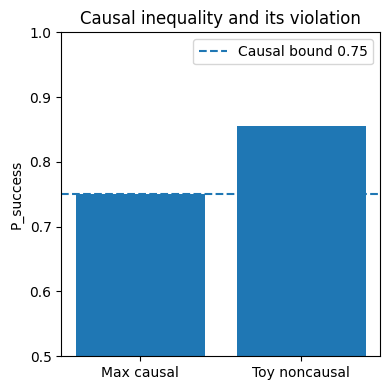

(0.75, 0.85483)

In [7]:
max_causal = max(r[3] for r in results_sorted)  # <= 0.75
noncausal = p_nc

import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
plt.bar(["Max causal", "Toy noncausal"], [max_causal, noncausal])
plt.axhline(0.75, linestyle="--", label="Causal bound 0.75")
plt.ylim(0.5, 1.0)
plt.ylabel("P_success")
plt.title("Causal inequality and its violation")
plt.legend()
plt.tight_layout()
plt.show()

max_causal, noncausal
